# Customer Churn Analysis - Gradient Boosted Trees

<font color='red'> ! Please do not copy, cite, or distribute without permission. 

## I. Introduction

In this analysis, we will predict costomer churn, whether a customer will leave or not, using gradient boosted trees. We are going to use the `Telco Churn Dataset` from the IBM Base Samples. This dataset will allow us to predict if someone will stop using Telco's services or not using a variety of continuous and categorical datatypes. 

Please see the official documentation of this data set provided by IBM to learn more about the dataset. https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=samples-telco-customer-churn

####  Gradient Boosted Trees

Like random forests, gradient boosted trees are ensembling methods that perform regression or classification by combining the outputs from individual trees. However, Random forests and gradient boosted trees differ in the way the individual trees are built and in the way the results are combined. 

While random forest builds independent decision trees and combine them in parelle, gradient boosting uses a method call boosting. Boosting combines weak learners sequentially so that each new tree corrects the erros of the previous one. 


## II. Import the data

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_csv(f'../data/Telco_Customer_Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## III. Preprocessing 

In [5]:
# First, we will drop the customer ID because it is simply a unique identifier assigned to each customer. 
df.drop(['customerID'], axis=1, inplace =True)

### Missing data 

One thing that is relatively unique about XGBoost is that it has defualt behavior for missing data. So all we have to do is identify missing values and set them to 0.

In [12]:
# The number of missing data in the TotalCharges column.
len(df.loc[df['TotalCharges']== ' '])

11

In [13]:
df.loc[df['TotalCharges']== ' ']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


We see these 11 people with empty total charge values have just signed up becuse their tenure value is 0. 
These people also have Churn set to NO because they just singed up. So we have a few choices here. We can set total charges to 0 or we can remove them. In this example, we will try setting it to 0. 

In [14]:
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = 0

In [15]:
# Confrim the changes.
df.loc[df['tenure'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,No


However, TotalCharges still has the object data type. That is no good because XBGoost only allows int, float, or boolean data types. Let's consolidate the data types. 

In [17]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

### Whitespaces

Now that we have dealt with the missing data, we can replace all of the other whitespaces in all of the columns with underscores. Please note that we are only doing this so we can draw a picture of the one of the XGBoost trees.

In [18]:
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


### Spliting Xs and Ys 
We will use the conventional notation of X to represent the columns of data that we will use to make classifcations and y to represent the thing we want to predict. In this case, we want to predict Churn value. 

In [21]:
# Convert Yes/No to 1/0.
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [22]:
X = df.drop('Churn', axis =1).copy()
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65


In [23]:
y = df['Churn'].copy()
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

### One hot encoding

In [27]:
X.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

All of the columns that are object type need to be inspected to make sure they only contain resonable values. This is because while XGBoost natively supports continuous data like TotalCharges, it does not natively support categorical data lilke PhoneService.
Thus, in order to use categorical data with XGBoost, we have to use a trick that converts a column of categorical data into multiple columns of binary values. 

Another important question is "why we can't just treat the categorical data like continuous data?" To answer that question, let's look at an exmpale. For example, the PaymentMethod column has a bunch of options:

1. Mailed_Check
2. Electornic_Check
3. Bank_Transfer
4. Credit_Card

If we converted these categories to numbers, 1, 2, 3, and 4, treated them like continuous data, then we would assume that 4, which means creadit card, is more simiar to 3, which means Bank transfer, than it is to 1 or 2, which are other form of payments. That means the XGBoost Tree would be more likely to cluster the people wiht 4s and 3s together than the people with 4s and 1s together. In contrast, if we treat these payment methods like categorical data, then we treat each one as a separate category that is no more or less similar to any of the other categories. 

Therefore, we can use a technique called One Hot Encoding to avoid this issue and correctly represent the categorical features in the dataset. 

In [28]:
pd.get_dummies(X, columns = ['PaymentMethod']).head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,...,No,No,Month-to-month,Yes,29.85,29.85,0,0,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One_year,No,56.95,1889.50,0,0,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,...,No,No,One_year,No,42.30,1840.75,1,0,0,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0


In [30]:
X_encoded = pd.get_dummies(X, columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                                        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                                        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                        'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'])

In [31]:
X_encoded.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,1,29.85,29.85,1,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,1,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [32]:
# Last thing -  we need to verify that y only contains 1s and 0s.
y.unique()

array([0, 1], dtype=int64)

### Train/Test Split

Prior to the analysis, let's observe that this data is imbalanced by dividing the number of people who left the company by the total number of people in the dataset. 

In [33]:
sum(y)/len(y)

0.2653698707936959

We can see that only 26.5% of the people in the dataset left the company. Because of this, when we split the data into training and testing, we will use stratification in order to maintain the same percentage of people who left the company in both the training set and the testing set. 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [36]:
sum(y_train)/len(y_train)

0.2654297614539947

In [37]:
sum(y_test)/len(y_test)

0.26519023282226006

## IV. Modeling:  XGBoost for gradient boosted trees

Instead of determining the optimal number of trees with cross validation, we will use early stopping to stop building trees when they no longer improve the situation. 

In [49]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', missing =0, seed =42)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.63160
[1]	validation_0-aucpr:0.64538
[2]	validation_0-aucpr:0.64402
[3]	validation_0-aucpr:0.64429
[4]	validation_0-aucpr:0.63866
[5]	validation_0-aucpr:0.63420
[6]	validation_0-aucpr:0.63911
[7]	validation_0-aucpr:0.63778
[8]	validation_0-aucpr:0.63772
[9]	validation_0-aucpr:0.63890
[10]	validation_0-aucpr:0.63676


C:\Users\HKo\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=0,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

We've built an XGBoost model for classification. Let's see how it performs on the Testing Dataset by running the Testing Dataset down the model and drawing a confusion matrix. 

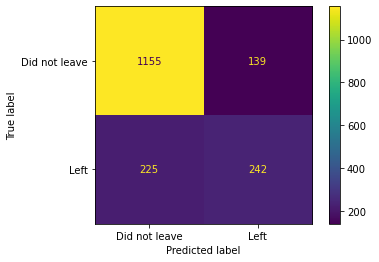

In [46]:
plot_confusion_matrix(clf_xgb, 
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels = ["Did not leave", "Left"])

In the confusion matrix, we see that of the 1294 people who did no leave, 1155 (89%) were correctly classified. And of the 467 people who left the company, 242 (51%) were correctly classified. So the XGBoost model was not awesome. Part of the problem is that our data is imbalanced. Because people leaving costs the company a lot of money, we would like to capture more of the people that left. The good news is that XGBoost has a parameter, scale_pst_weight, that helps with imbalanced data. It adds a penalty for incorrectly classifying the minority class. In this case, the people that left the company. So let's try to improve predictions using cross validation to optimize the parameters. 

## V. Optimize Parameters using Corss Validation and GridSearch()

XGBoost has a lot of hyperparameters, parameters that we have to manually configure and are not determined by XGBoost itself, including max_depth, maximum tree depth, learning_rate, the learning rate, or "eta", gamma, the parameter that encourages pruning, and reg_lambda, the regularization parameter lambda. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the Testing Dataset. 

Since we have many parameters to optimize, we will use GridSearchCV(). We specify a bunch of potential values for the hyperparameters and GridSearchCV() tests all possible combinations of the parameters for us. 

Please note that I ran GridSearchCV sequentially on subsets of parameter options, rather than all at once, in order to optimize parameters in a short period of time.

In [62]:
### Round1

# param_grid = {
#         'max_depth' : [3, 4, 5],
#         'learning_rate': [0.1, 0.01, 0.05],
#         'gamma': [0, 0.25, 1.0],
#         'reg_lambda': [0, 1.0, 10.0],
#         'scale_pos_weight': [1, 3, 5]
# }


### Round2
param_grid = {
        'max_depth' : [3],
        'learning_rate': [0.05],
        'gamma': [1.0, 2.0],
        'reg_lambda': [10.0, 20, 100],
        'scale_pos_weight': [3]
}


# To speed up cross validation, and to further prevent overfitting,
# we are only using a random subset of the data (90%) and are only
# using a random subset of the features (columns) (50%) per tree. 

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                               seed = 42,
                               subsample =0.9, 
                               colsample_bytree=0.5), 
    param_grid=param_grid,
    scoring = 'roc_auc',
    verbose = 2,
    n_jobs =10,
    cv = 3  #number of cross validations

)

optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='auc',
                   eval_set=[(X_test, y_test)],
                   verbose=False)

print(optimal_params.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\HKo\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


After testing all possible combinations of the potential parameter values with cross validation, we see that we should set gamma=1.0, learning_rate = 0.05, max_depth = 3, reg_lambda = 10, and scale_post_weight = 3.

## VI. Building, Evaluation, and Interpreting the XGBoost Model 

In [63]:
clf_xgb = xgb.XGBClassifier(seed = 42,
                            objective = 'binary:logistic',
                            gamma = 1.0,
                            learn_rate = 0.05,
                            max_depth = 3,
                            reg_lambda =10,
                            scale_pos_weight = 3,
                            subsample = 0.9,
                            colosample_bytree=0.5)

clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds = 10,
           eval_metric = 'aucpr',
           eval_set = [(X_test, y_test)])

[21:29:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "colosample_bytree", "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.57441
[1]	validation_0-aucpr:0.59651
[2]	validation_0-aucpr:0.60905
[3]	validation_0-aucpr:0.61105
[4]	validation_0-aucpr:0.61817
[5]	validation_0-aucpr:0.62229
[6]	validation_0-aucpr:0.64225
[7]	validation_0-aucpr:0.63975
[8]	validation_0-aucpr:0.64294
[9]	validation_0-aucpr:0.64196
[10]	validation_0-aucpr:0.64613
[11]	validation_0-aucpr:0.64979
[12]	validation_0-aucpr:0.65000
[13]	validation_0-aucpr:0.65104
[14]	validation_0-aucpr:0.65019
[15]	validation_0-aucpr:0.65197
[16]	validation_0-aucpr:0.65049
[17]	validation_0-aucpr:0.

XGBClassifier(base_score=0.5, booster='gbtree', colosample_bytree=0.5,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=1.0, gpu_id=-1,
              importance_type=None, interaction_constraints='', learn_rate=0.05,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=10, scale_pos_weight=3,
              seed=42, subsample=0.9, tree_method='exact',
              validate_parameters=1, ...)

Now, let's draw another confusion matrix to see if the optimized XGBoost model does better. 

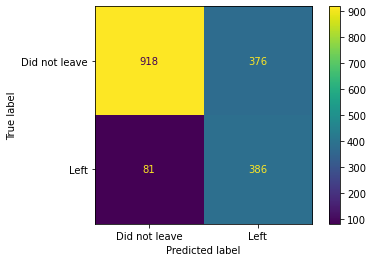

In [64]:
plot_confusion_matrix(clf_xgb, 
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels = ["Did not leave", "Left"])

We see that the optimized XGBoost model is a lot better at identifying people that left the company. Of the 467 people that left the company, 386 (82%) were correctly identified. Before optimization, we only correctly identified 52%. However, this improvement was at the expense of not being able to correcly classify as many people that did not leave. 

Although the improvement was at the expesne of not being able to correctly classify those who did not leave, this type of error is better compared to missclassifying cusomters who actually left. Since customers leaving the company negatively affects the company's revenues, it is more important to correctly identify them.  

## VII. XGBoost Tree 

In [ ]:
# We just need to build the first tree, otherwise we'll get the average over all of the trees.
clf_xgb = xbg.XGBClassifier(seed =42,
                            objective = 'binary:logistic',
                            gamma = 1.0,
                            learn_rate = 0.05,
                            max_depth = 3,
                            reg_lambda =10,
                            scale_pos_weight = 3,
                            subsample = 0.9,
                            colosample_bytree=0.5,
                            n_estimators=1) # we only want to build one tree. 

clf_xgb.fit(X_train, y_train)

weight:  {'tenure': 38.0, 'MonthlyCharges': 52.0, 'TotalCharges': 64.0, 'gender_Female': 3.0, 'SeniorCitizen_0': 5.0, 'Partner_No': 1.0, 'Dependents_No': 4.0, 'PhoneService_No': 2.0, 'MultipleLines_No': 5.0, 'MultipleLines_Yes': 1.0, 'InternetService_DSL': 2.0, 'InternetService_Fiber_optic': 4.0, 'OnlineSecurity_No': 6.0, 'OnlineBackup_No': 7.0, 'DeviceProtection_No': 1.0, 'TechSupport_No': 5.0, 'TechSupport_Yes': 4.0, 'StreamingTV_No': 1.0, 'StreamingTV_Yes': 1.0, 'StreamingMovies_No': 1.0, 'StreamingMovies_Yes': 2.0, 'Contract_Month-to-month': 6.0, 'Contract_One_year': 5.0, 'Contract_Two_year': 3.0, 'PaperlessBilling_No': 5.0, 'PaymentMethod_Bank_transfer_(automatic)': 7.0, 'PaymentMethod_Credit_card_(automatic)': 1.0, 'PaymentMethod_Electronic_check': 7.0, 'PaymentMethod_Mailed_check': 2.0}
gain:  {'tenure': 21.08059310913086, 'MonthlyCharges': 10.474363327026367, 'TotalCharges': 7.549922943115234, 'gender_Female': 5.36404275894165, 'SeniorCitizen_0': 9.637134552001953, 'Partner_No'

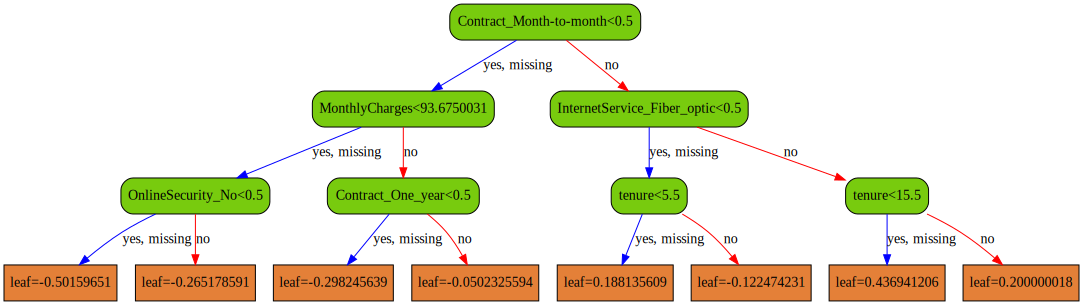

In [66]:
## weight = the number of times a feature is used in a branch or root across all trees.
## gain = the average gain across all splits that the feature is used in.
## cover = the agerage coverage across all splits a feature is used in.
## total_gain = the total gain across all splits the feature is used in.
## total_cover = the total coverage across all splits the feature is used in.
## please note that since we only built one tree, gain = total_gain, and cover = total_cover

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type = importance_type))
    
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}

leaf_params = {'shape': 'box',
              'style': 'filled',
               'fillcolor':'#e48038'}


xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

Please note that the leaves don't give us classifications. Leaves give us a small incremental piece of probability that we add together for all of the trees and that gives us the final probability that an observation is one classifciation or the other: whether a customer is either going to leave the company or not. 